Zuerst Bibliotheken laden

In [3]:
!pip install HanTa

     |████████████████████████████████| 1.5MB 2.7MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
import pandas as pd
from os.path import join
import os



In [5]:
# für Hanover Tagger
from HanTa import HanoverTagger as ht
tagger = ht.HanoverTagger('morphmodel_ger.pgz')
from pprint import pprint

# Bibliotheken für nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer

nltk.download ('stopwords')
nltk.download('punkt')

stemmer = SnowballStemmer("german")

stop_words_nltk = set(stopwords.words('german'))
th_words = [ ".", ",", ";", ":","?","!","'",'"',"'s"]

stop_words_th = set((u'–', u'.', u';', u'?', u':', u'!', u"'s", u'"', u"/n"))
stop_words = stop_words_nltk | stop_words_th



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Hier wird erst einmal der Text eingelesen, der untersucht wird.

In [11]:
# Diese Prozedur sucht zum Buch-Namen - abgekürzt mit 3 Buchstaben alle Verse und schreibt sie in den return-Wert als String
def bibel_lesen(buch):
  luther = open('/content/drive/My Drive/luther/luther.txt','r')

  a    = ""
  text = ""
  lfnr = 0
  zeile = luther.readline()

  # Bibel durchlesen
  while a is not "stop" :
     # wenn eine Zeile aus dem richtigen Buch gefunden wurd
     z_buch = zeile[:3]

     if z_buch == buch:
       # dann das Buch rauskopieren
       z_bst_leer = zeile[4:].find(" ") # erstes Leerzeichen nach Buch-Abk + 1 = 4 Zeichen
       text = text + " " + zeile[4 + z_bst_leer:]  # Buchnamen + Verszählung abschneiden
       a = "start"
     # wenn das Buch nicht passt, prüfen, ob es gerade gelesen wurde  
     else:
       if a == "start":
         a = "stop" # damit Schleife anhält
 
     # nächsten Vers lesen
     lfnr = lfnr + 1
     zeile = luther.readline()

  luther.close()
  return(text)

In [6]:
# welche Bücher hat dieser Text?
luther = open('/content/drive/My Drive/luther/luther.txt','r')

buch_liste = []

b_alt = "xxx"
zeile = luther.readline()

while zeile > "":
  b = zeile[0:3]
  if b != b_alt:
    buch_liste.append(b)
    b_alt = b
  zeile = luther.readline()


luther.close()

print(buch_liste)

['Gen', 'Exo', 'Lev', 'Num', 'Deu', 'Jos', 'Jdg', 'Rut', '1Sa', '2Sa', '1Ki', '2Ki', '1Ch', '2Ch', 'Ezr', 'Neh', 'Est', 'Job', 'Psa', 'Pro', 'Ecc', 'Sol', 'Isa', 'Jer', 'Lam', 'Eze', 'Dan', 'Hos', 'Joe', 'Amo', 'Abd', 'Jon', 'Mic', 'Nah', 'Hab', 'Zep', 'Hag', 'Zec', 'Mal', 'Mat', 'Mar', 'Luk', 'Joh', 'Act', 'Rom', '1Co', '2Co', 'Gal', 'Eph', 'Phi', 'Col', '1Th', '2Th', '1Ti', '2Ti', 'Tit', 'Phm', 'Heb', 'Jam', '1Pe', '2Pe', '1Jo', '2Jo', '3Jo', 'Jud', 'Rev']


Hier kommt die eigentliche Textmining- Analyse

In [12]:
# Top 10 nound + verbs im Text bestimmen

def top10(text):
    sentences = nltk.sent_tokenize(text,language='german')
    #tokenized_sent = nltk.tokenize.word_tokenize(text,language='german')

    nouns = [] 
    verbs = []
    adja  = []
    sentences_tok = [nltk.tokenize.word_tokenize(sent) for sent in sentences]
    for sent in sentences_tok:
        tags = tagger.tag_sent(sent) 
        nouns_from_sent = [lemma for (word,lemma,pos) in tags if pos == "NN" or pos == "NE"]
        nouns.extend(nouns_from_sent)
        verbs_from_sent = [lemma for (word,lemma,pos) in tags if pos[:2] == "VV"]
        verbs.extend(verbs_from_sent)
        adja_from_sent = [lemma for (word,lemma,pos) in tags if pos == "ADJA"]
        adja.extend(adja_from_sent)

    fdist       = nltk.FreqDist(nouns) 
    anz_n       = fdist.N()
    anz_n_tok   = 0 #counts(fdist.keys)

    n10 = fdist.most_common(10)
    n10_proz = []
    for (a,b) in n10:
        c = round(100*b/anz_n,2)
        n10_proz.append((a,c))

    fdist       = nltk.FreqDist(verbs) 
    anz_v       = fdist.N()
    anz_v_tok   = 0 #counts(fdist.keys)

    v10 = fdist.most_common(10)
    v10_proz = []
    for (a,b) in v10:
        c = round( 100*b/anz_v,2)
        v10_proz.append((a,c))

    fdist       = nltk.FreqDist(adja) 
    anz_a       = fdist.N()
    anz_a_tok   = 0 #counts(fdist.keys)

    a10 = fdist.most_common(10)
    a10_proz = []
    for (a,b) in a10:
        c = round( 100*b/anz_a,2)
        a10_proz.append((a,c))

    #print(anz_n, anz_n_tok, anz_v, anz_v_tok)
    return(n10_proz,v10_proz, a10_proz, anz_n, anz_v, anz_a)
    # print(n10_proz)
    # print(v10_proz)
    # fdist.plot(50,cumulative=False)


In [15]:
# Dieses Buch wird bearbeitet
def haupt_je_buch(buch):
    text          = bibel_lesen(buch)
    n10, v10, a10, n, v, a = top10(text)
    print("--------------- ",buch," ---------------")
    print(n10)
    print(v10)
    print(a10)
    print(n,v,a)
    print("--------------- --- ---------------")
    return(n,v,a)

kennzahlen = []
for b in buch_liste[0:5] + buch_liste[-27:-23]:     #-27:-23
    # Dieses Buch wird bearbeitet
    n,v,a = haupt_je_buch(b)
    kennzahlen.append((b, n, v, a))


---------------  Gen  ---------------
[('Herr', 3.1), ('Sohn', 2.86), ('Gott', 2.82), ('Vater', 2.48), ('Land', 2.18), ('Bruder', 2.11), ('Jakob', 2.08), ('Kind', 1.79), ('Joseph', 1.68), ('Erde', 1.52)]
[('sprechen', 9.8), ('sehen', 4.56), ('kommen', 3.71), ('nehmen', 2.92), ('geben', 2.79), ('gehen', 2.48), ('werden', 2.42), ('lassen', 2.42), ('tun', 2.42), ('ziehen', 2.38)]
[('ganz', 7.4), ('groß', 5.78), ('jung', 4.33), ('lebendig', 3.07), ('ander', 2.53), ('erster', 2.35), ('anderer', 2.35), ('alt', 2.35), ('oberer', 2.35), ('eu', 2.17)]
7878 4798 554
--------------- --- ---------------
---------------  Exo  ---------------
[('Herr', 6.63), ('Mose', 3.89), ('Volk', 2.69), ('Israel', 2.58), ('Kind', 2.42), ('Gott', 2.2), ('Aaron', 1.77), ('Pharao', 1.75), ('Hand', 1.51), ('Tag', 1.32)]
[('sprechen', 6.45), ('machen', 5.92), ('tun', 4.2), ('lassen', 3.52), ('sehen', 3.34), ('gehen', 2.99), ('kommen', 2.57), ('nehmen', 2.4), ('sagen', 2.13), ('geben', 1.89)]
[('golden', 5.81), ('blau

['Gen', 'Exo', 'Lev', 'Num', 'Deu', 'Mat', 'Mar', 'Luk', 'Joh']


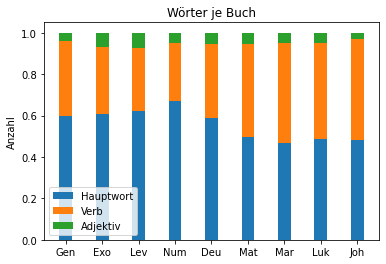

In [17]:
# n-a-v auszählen
labels=[]
nouns=[]
verbs=[]
adjs=[]
for l,n,v,a in kennzahlen:
    labels.append(l)
    nouns.append(n/(n+v+a))
    verbs.append(v/(n+v+a))
    adjs.append(a/(n+v+a))

print(labels)

width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
# Hilfsvariable
nv  = np.add(nouns, verbs).tolist()
nva = np.add(nv, adjs).tolist()

ax.bar(labels, nouns, width, label='Hauptwort')
ax.bar(labels, verbs, width, bottom=nouns, label='Verb')
ax.bar(labels, adjs,  width, bottom=nv, label='Adjektiv')

ax.set_ylabel('Anzahl')
ax.set_title('Wörter je Buch')
ax.legend()

plt.show()

In [ ]:
# Text in Wörter häckseln
tokens = word_tokenize(text,language='german')

# stop-words entfernen
filtered_text = []

for w in tokens:
    if w.lower() not in stop_words:
        filtered_text.append(w)

# Remove single-character tokens (mostly punctuation)
filtered_text = [word for word in filtered_text if len(word) > 1]

# print(filtered_text[0:5])

# stemming
stem_text = []
for w in filtered_text:
  stem_w = stemmer.stem(w)
  stem_text.append(stem_w)

# print(stem_text[0:5])  

# Top 15 ausgeben
all_words = nltk.FreqDist(stem_text)
print(all_words.most_common(15))
top15 = all_words.most_common(15)

In [ ]:
#print(len(stop_words))
#print(stop_words)
# print(sum(all_words.freq))
#  nltk.collocations.BigramCollocationFinder
anz_worte = all_words.N()
anz_tok   = len(set(stem_text))

proz_liste = []
for (a,b) in top15:
  c = 100*b/anz_worte
  proz_liste.append((a,c))

print(proz_liste)

In [1]:
#Location of a word in the text: how many spaces from the beginning does it appear? 

#This positional information can be displayed using a dispersion plot. 

#You need NumPy and Matplotlib. 

#text4.dispersion_plot(["citizens", "democracy", "freedom", "war", "America", "vote"])
#print(text)
#text = text.replace("\n", "")
#print(tags)

#print(n10_proz)
#print(v10_proz)
nva = np.add(nv, adjs).tolist()
n_proz = np.div(nv,adjs).toliste()

NameError: ignored